In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import load_data as ld
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models
print(tf.__version__)

2.6.0


In [2]:
ip_data = np.load("../data/htmp_data/all_net_ip_data.npy")
out_data = np.load("../data/htmp_data/all_net_out_data.npy")
ip_data.shape,out_data.shape

((52, 24, 72, 6), (52, 17))

In [3]:
model = keras.models.load_model("../data/model/exp2_pretrain")

In [11]:
pre_data = model.predict(ip_data[[15]])

In [12]:
pre_data

array([[ 0.89909226,  0.9422093 ,  1.4401245 ,  0.9935448 ,  1.236834  ,
         0.8175681 ,  1.0408186 ,  0.6451527 ,  0.59602   ,  0.4009684 ,
         0.6076407 ,  0.34005508,  0.25836384,  0.19253302,  0.29113853,
        -0.3226846 , -0.13311318]], dtype=float32)

In [13]:
out_data[15]

array([ 0.6786058 ,  0.5477082 ,  0.62628096,  0.8407384 ,  1.2400239 ,
        1.4360106 ,  1.5638688 ,  1.5485938 ,  1.5034913 ,  1.4391909 ,
        1.1580619 ,  0.82882947,  0.38046104,  0.17230658, -0.03019004,
       -0.03235938, -0.00939427], dtype=float32)

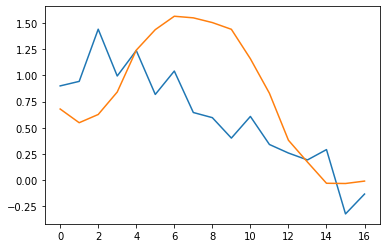

In [14]:
plt.plot(pre_data[0])
plt.plot(out_data[15])

In [15]:
last_conv_layer_name = "conv2d_2"
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)
grad_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 24, 72, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 72, 50)        9650      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 36, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 36, 50)        80050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 18, 50)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 18, 50)         80050     
_________________________________________________________________
flatten (Flatten)            (None, 5400)              0     

In [16]:
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(ip_data[[15]])
    class_channel = preds[:,0]
grads = tape.gradient(class_channel, last_conv_layer_output)
grads.shape,preds.shape

(TensorShape([1, 6, 18, 50]), TensorShape([1, 17]))

In [17]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
# pooled_grads = grads
pooled_grads.shape

TensorShape([50])

In [18]:
last_conv_layer_output = last_conv_layer_output[0]
last_conv_layer_output.shape

TensorShape([6, 18, 50])

In [19]:
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

In [20]:
heatmap = tf.squeeze(heatmap)

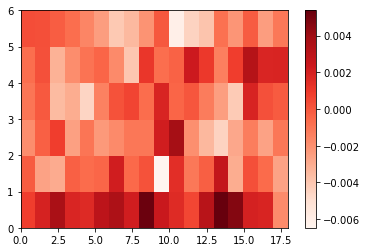

In [21]:
plt.pcolor(heatmap,cmap="Reds")
plt.colorbar()

In [22]:
lon = np.arange(0,356,5,dtype=float)
lat = np.arange(-55,61,5,dtype=float)

In [23]:
LON,LAT = np.meshgrid(lon,lat)

In [24]:
map_fun = keras.layers.AveragePooling2D((2,2))

In [25]:
lat1 = map_fun(map_fun(LAT[np.newaxis,:,:,np.newaxis]))[0,:,:,0]
lon1 = map_fun(map_fun(LON[np.newaxis,:,:,np.newaxis]))[0,:,:,0]

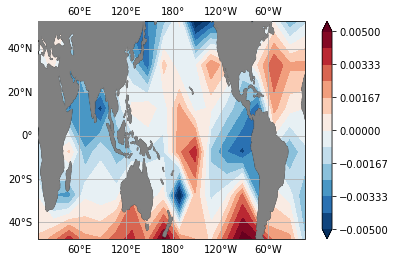

In [31]:
from tensorflow.python.ops.numpy_ops import np_config
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
np_config.enable_numpy_behavior()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
m = ax.contourf(lon1,lat1,heatmap+model.layers[-1].get_weights()[-1][6]/6/18,cmap="RdBu_r",
    transform=ccrs.PlateCarree(),levels=np.linspace(-0.005,0.005,13),
    extend="both")
plt.colorbar(m)
ax.set_aspect("auto")
ax.coastlines()
ax.add_feature(cft.LAND,color="gray",zorder=10)
ax.gridlines(draw_labels=True)

In [98]:
np.save("../data/htmp_data/lon1",lon1)
np.save("../data/htmp_data/lat1",lat1)
np.save("../data/htmp_data/1997ElNino",heatmap)